# Train model

In [1]:
#from main import run
#run(epochs=3, lr=0.01, batch_size=512)

# Evaluate model

In [2]:
import torch

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

/home/mk/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
from dataset import DwgDataset
dwg_dataset = DwgDataset('test_dataset_cluster_labeled.pickle', batch_size = 32, limit_seq_len=1000)

stroke_features = dwg_dataset.entities.stroke_features
max_seq_length = dwg_dataset.entities.max_seq_length

enc_hidden_size    = 256
dec_hidden_size    = 512

d_z=128
n_distributions    = 20

In [4]:
from model import DecoderRNN, EncoderRNN
encoder = EncoderRNN(d_z, enc_hidden_size, stroke_features=stroke_features)
decoder = DecoderRNN(d_z, dec_hidden_size, n_distributions, stroke_features=stroke_features)
encoder.to(device)
decoder.to(device)

# https://pytorch.org/tutorials/beginner/saving_loading_models.html
encoder.load_state_dict(torch.load('DimEncoder.model', map_location=device))
decoder.load_state_dict(torch.load('DimDecoder.model', map_location=device))

decoder.eval()
encoder.eval()

EncoderRNN(
  (lstm): LSTM(5, 256, bidirectional=True)
  (mu_head): Linear(in_features=512, out_features=128, bias=True)
  (sigma_head): Linear(in_features=512, out_features=128, bias=True)
)

In [5]:
import drawSvg as draw
from plot_graphics  import images_from_batch

In [6]:
from IPython.display import Image
from IPython.display import clear_output

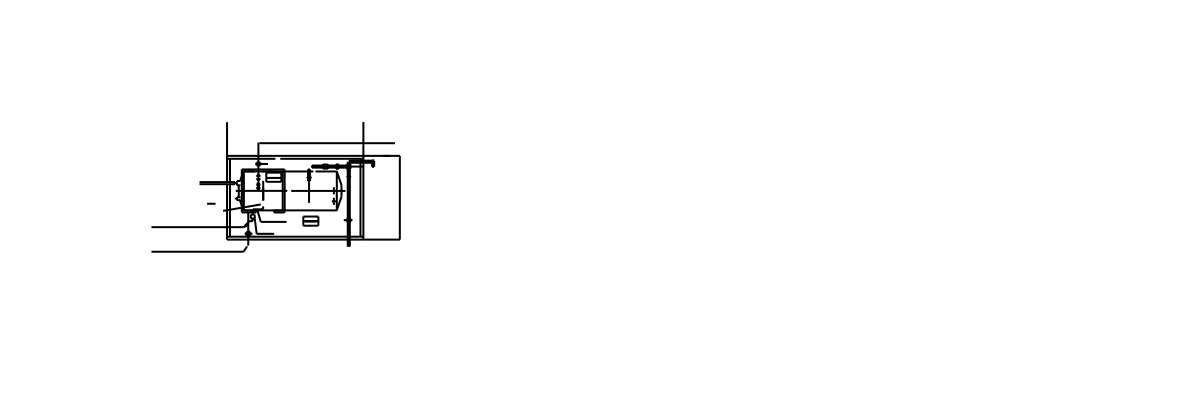

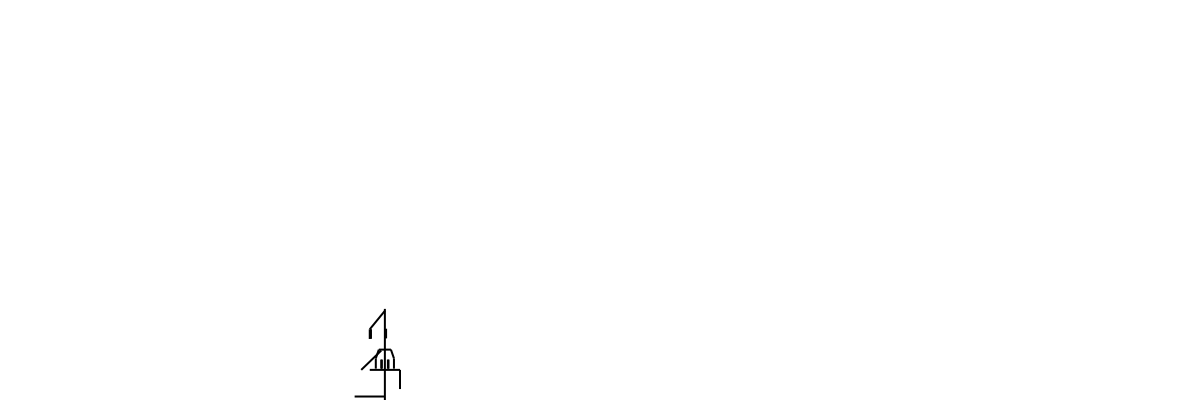

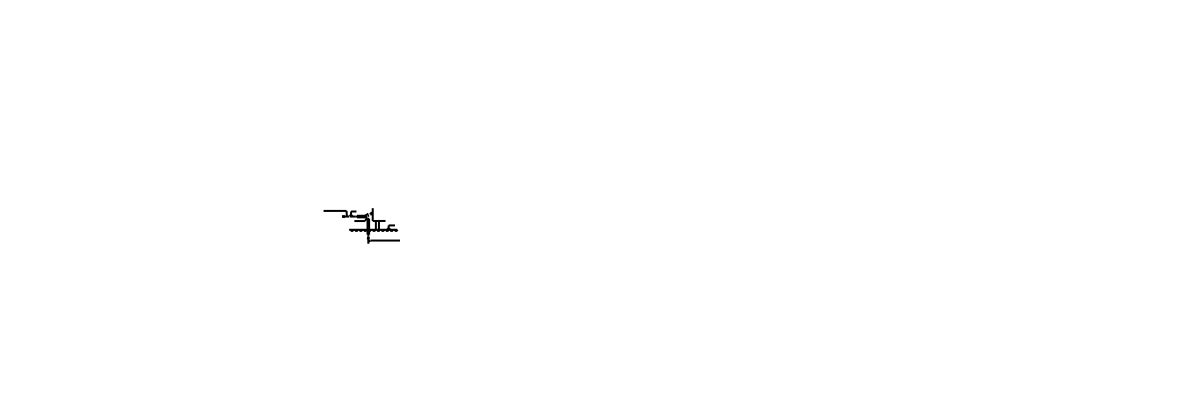

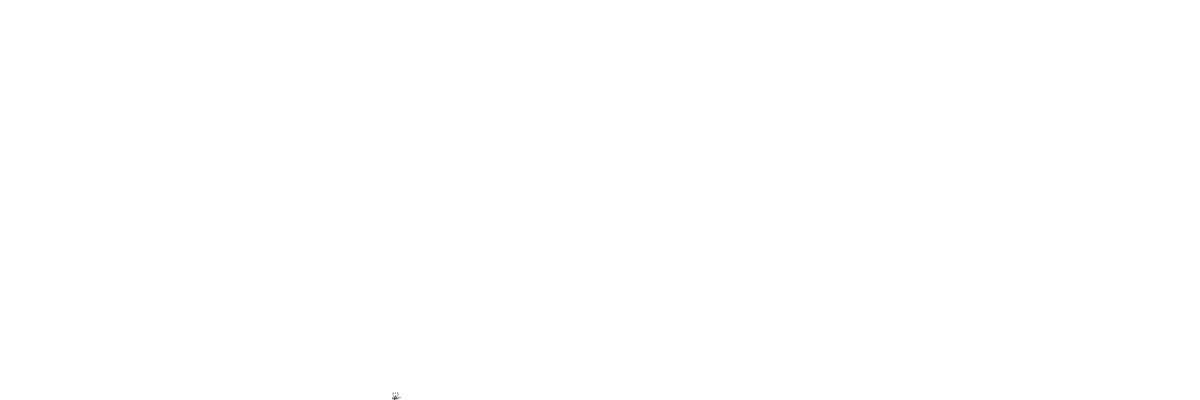

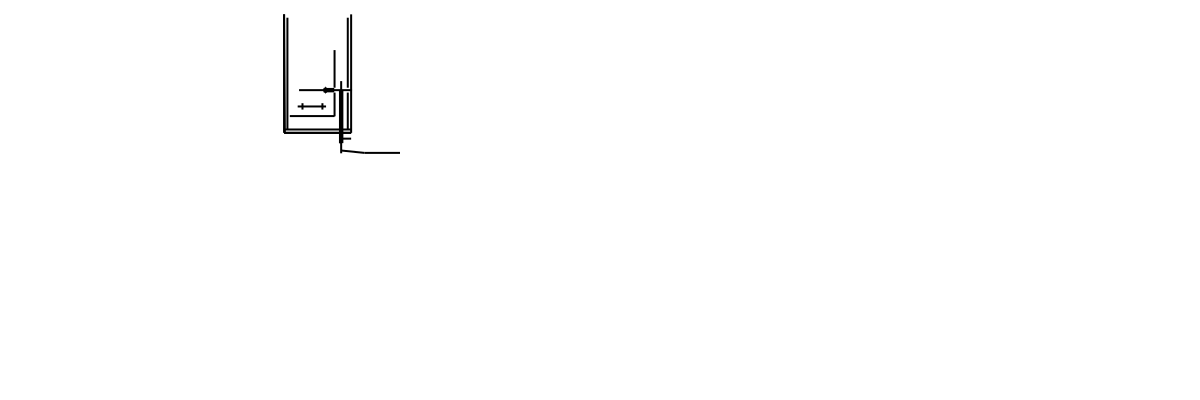

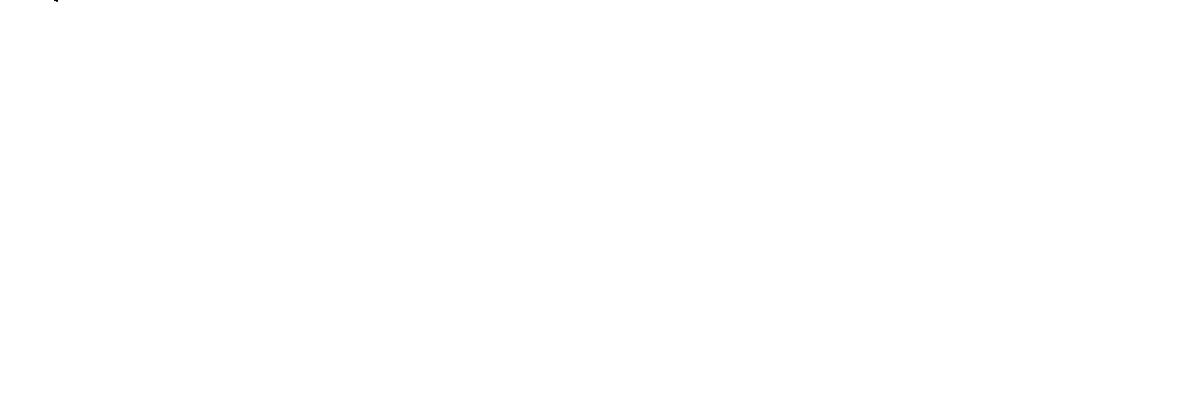

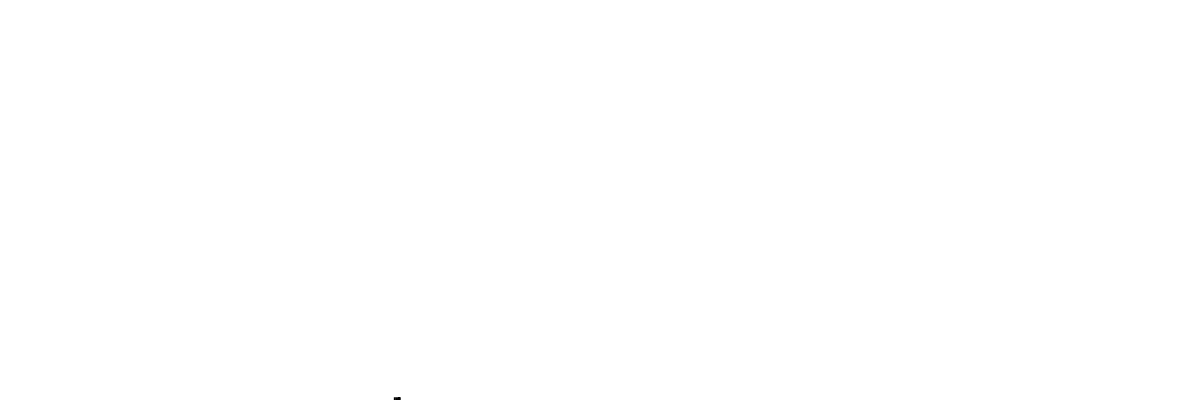

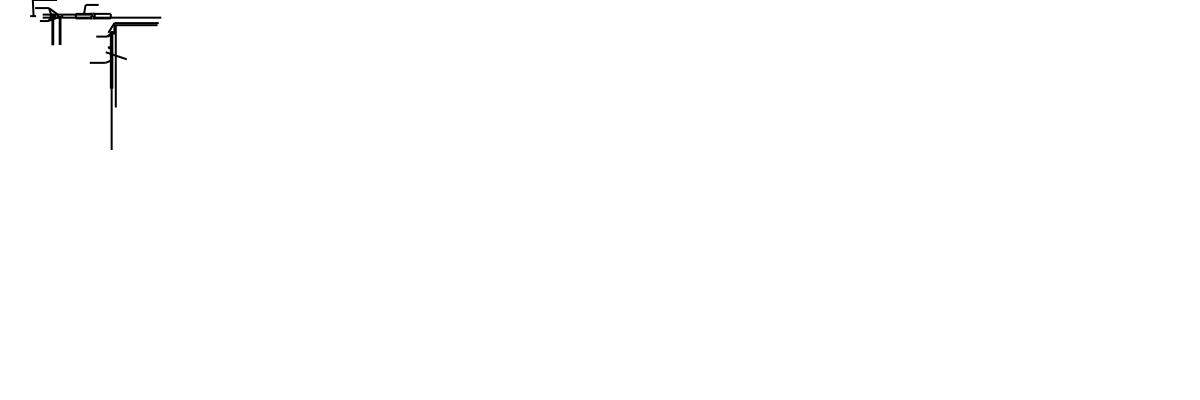

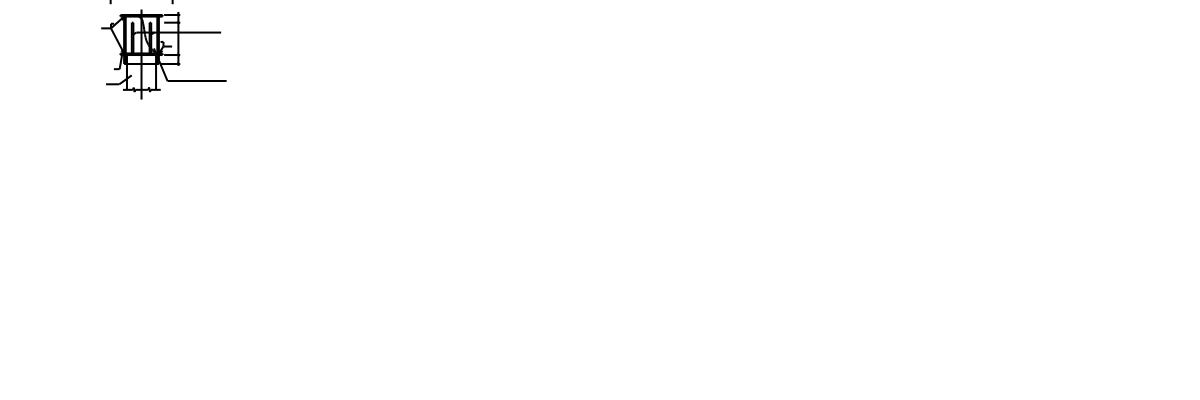

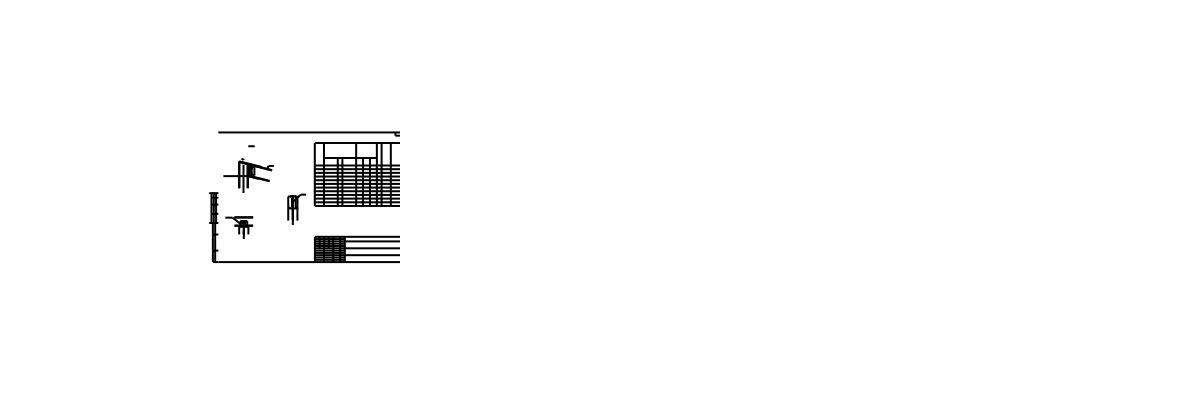

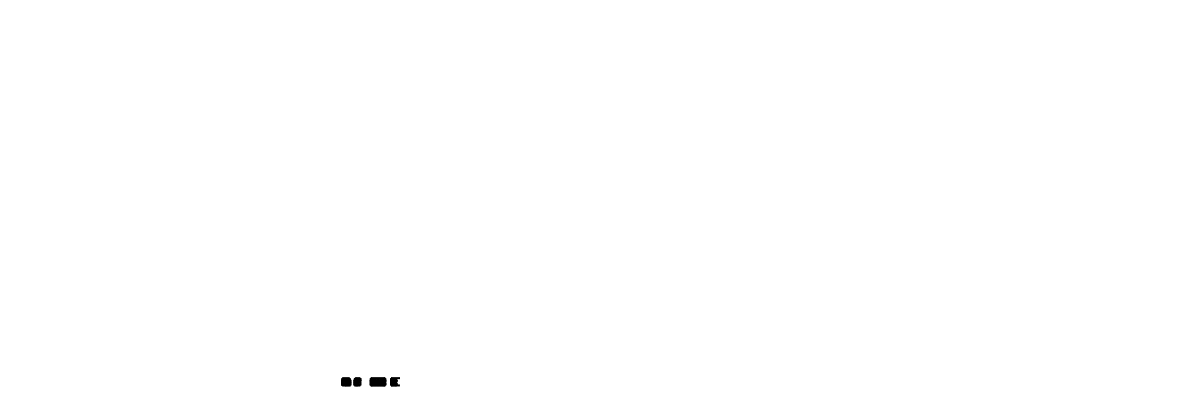

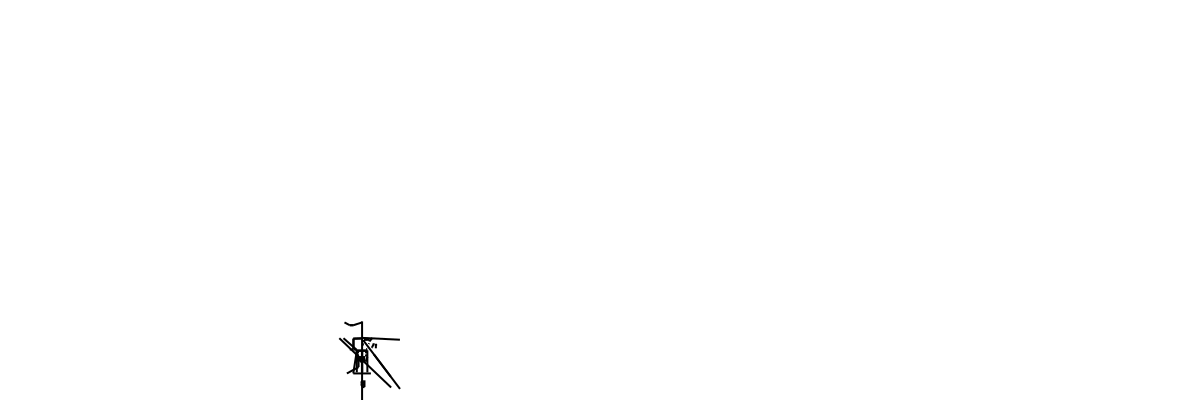

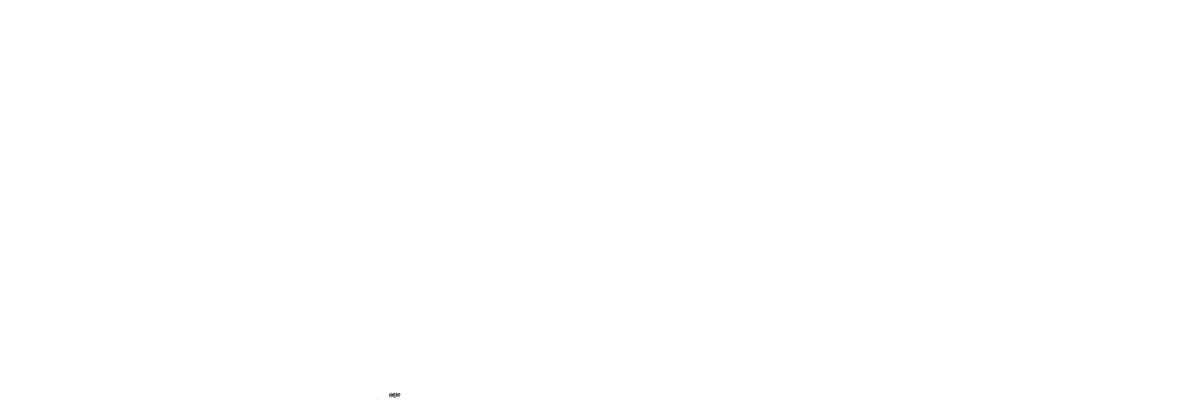

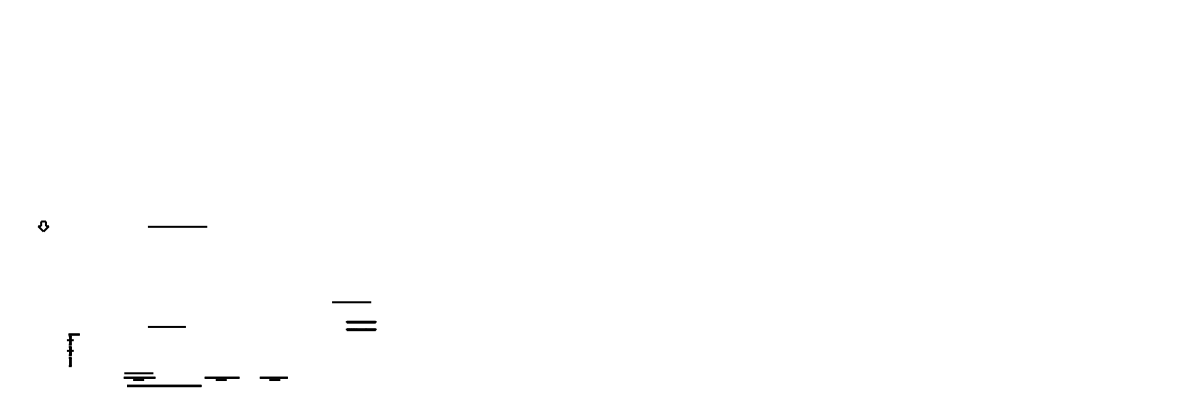

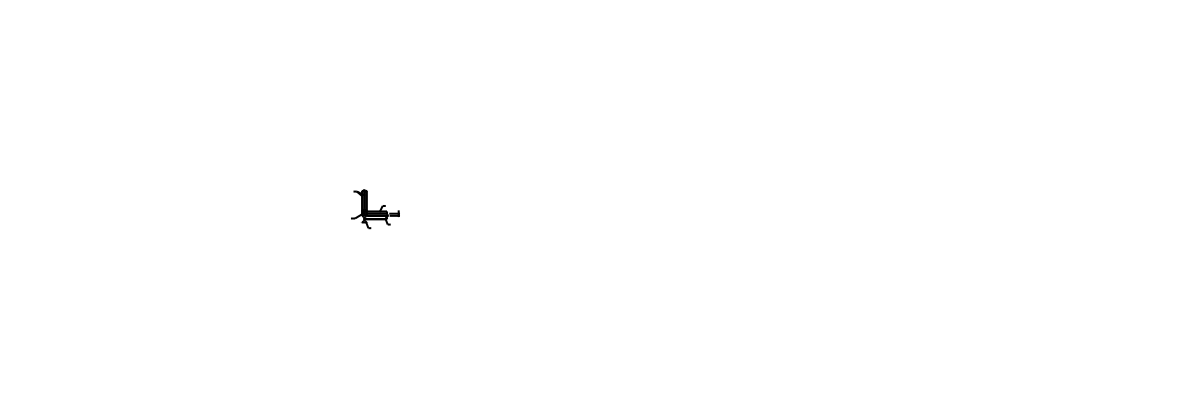

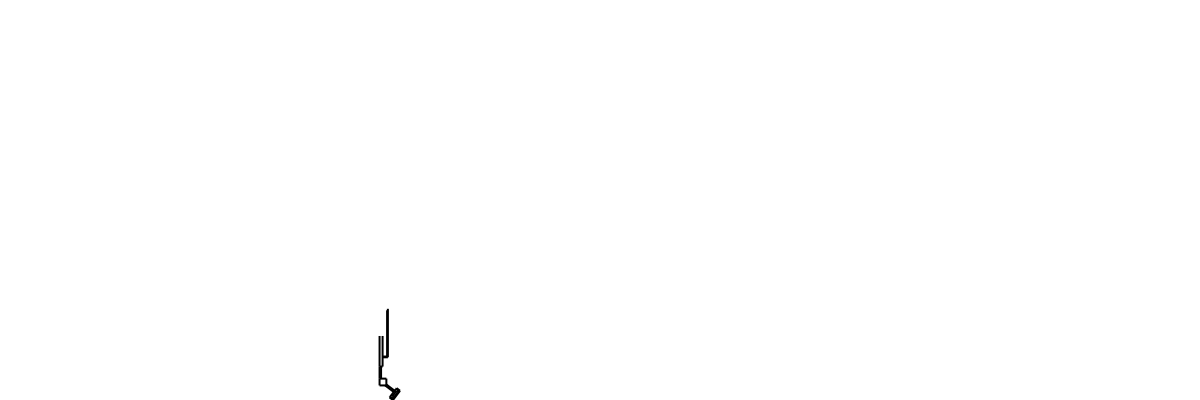

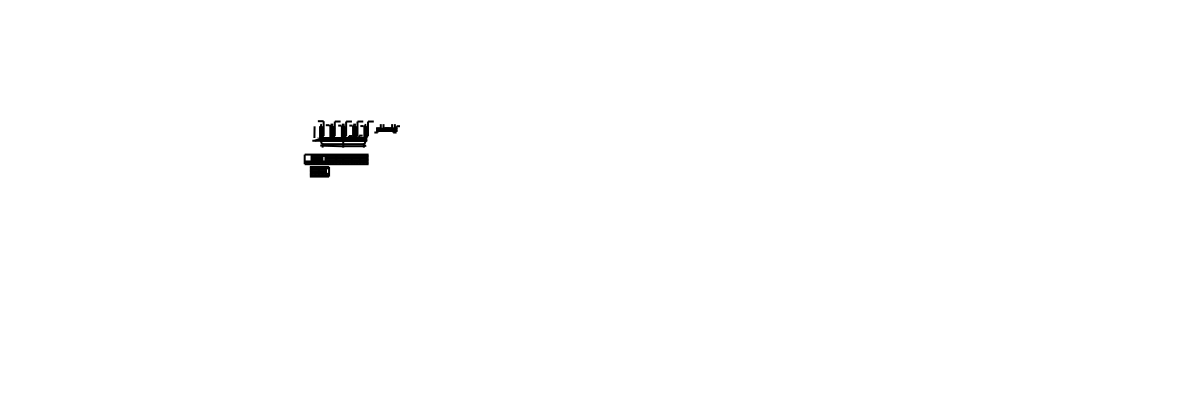

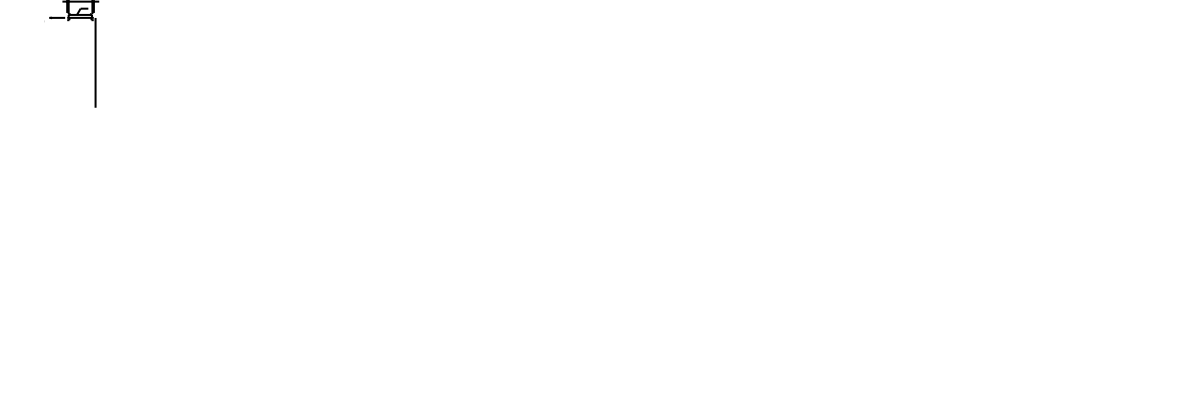

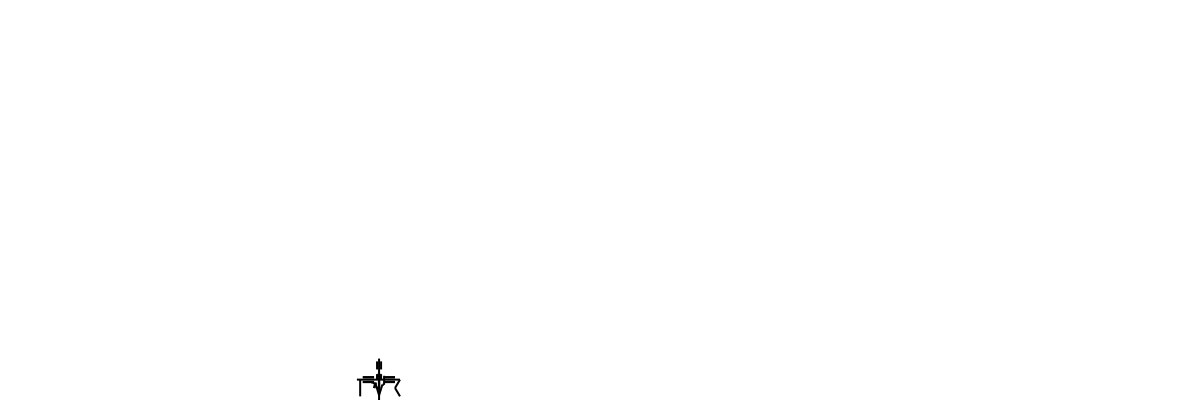

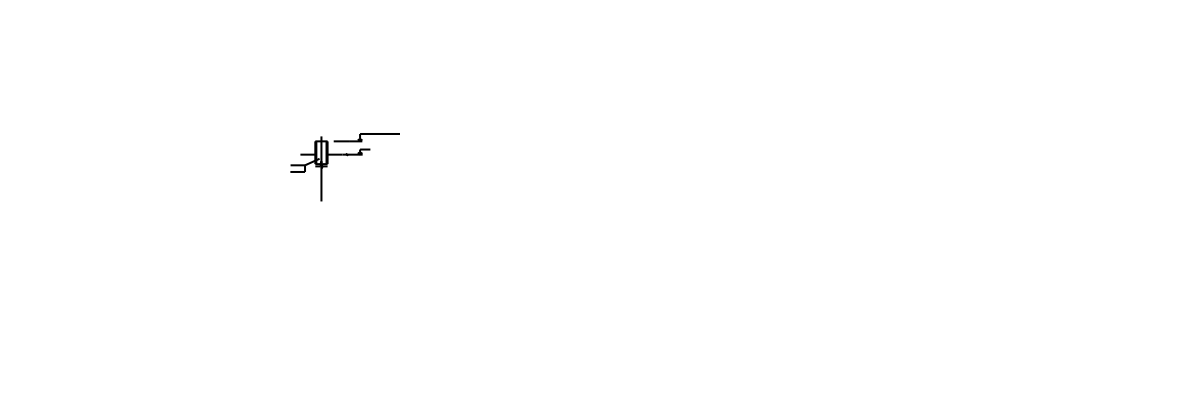

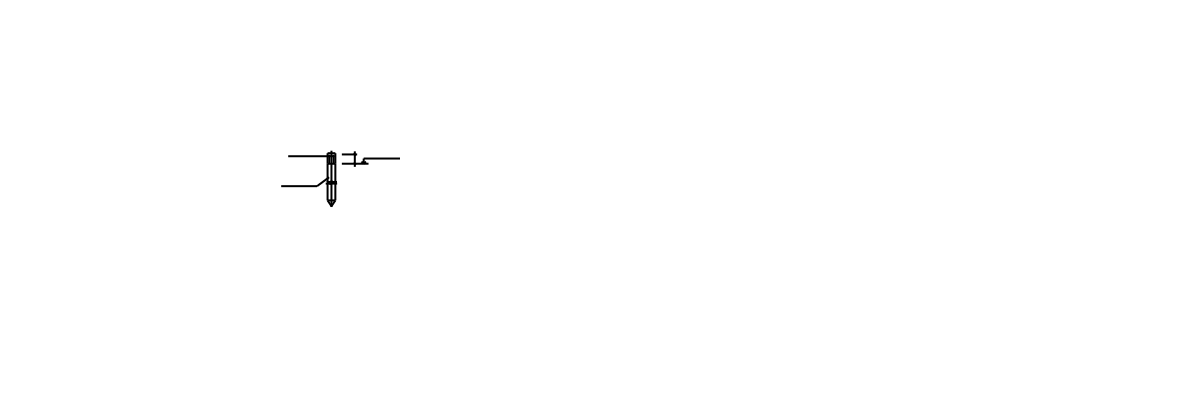

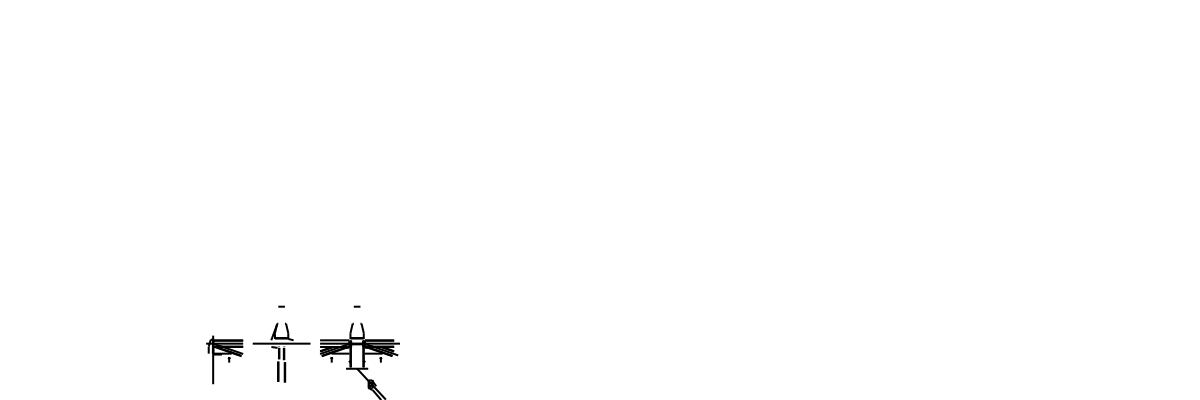

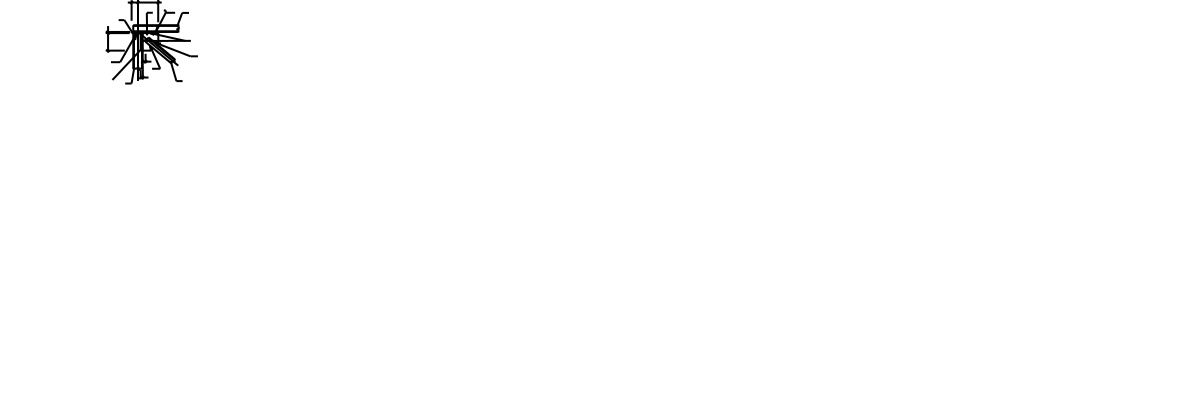

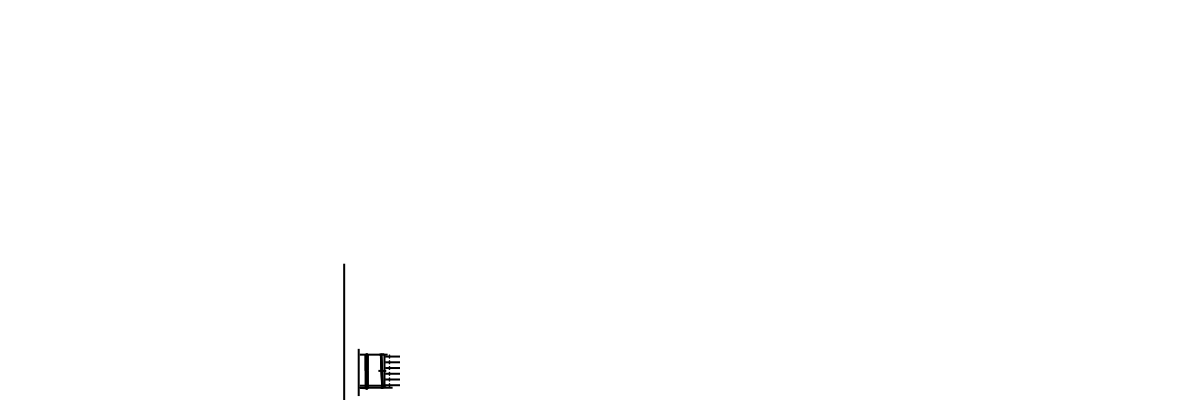

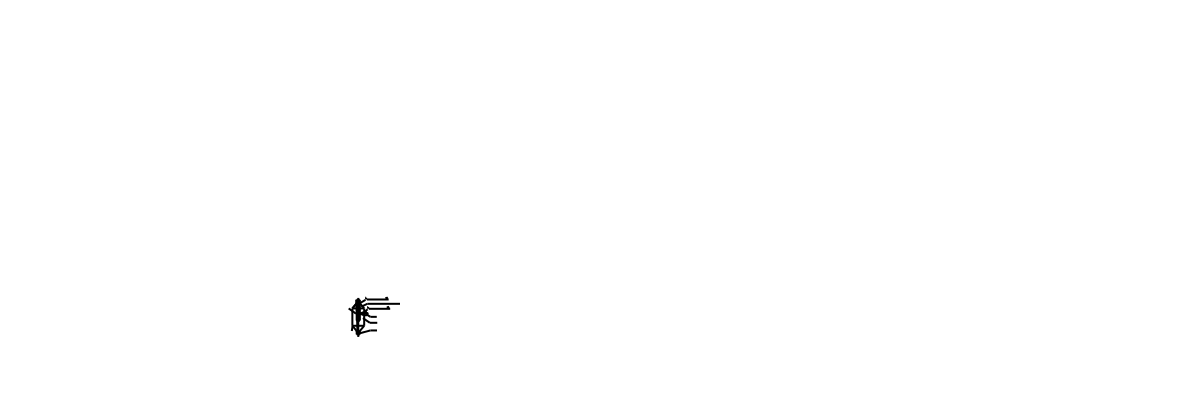

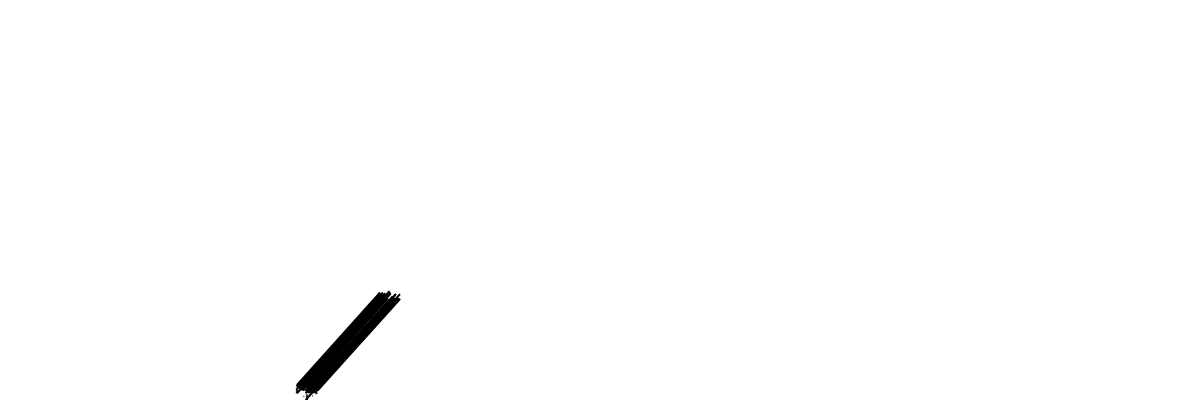

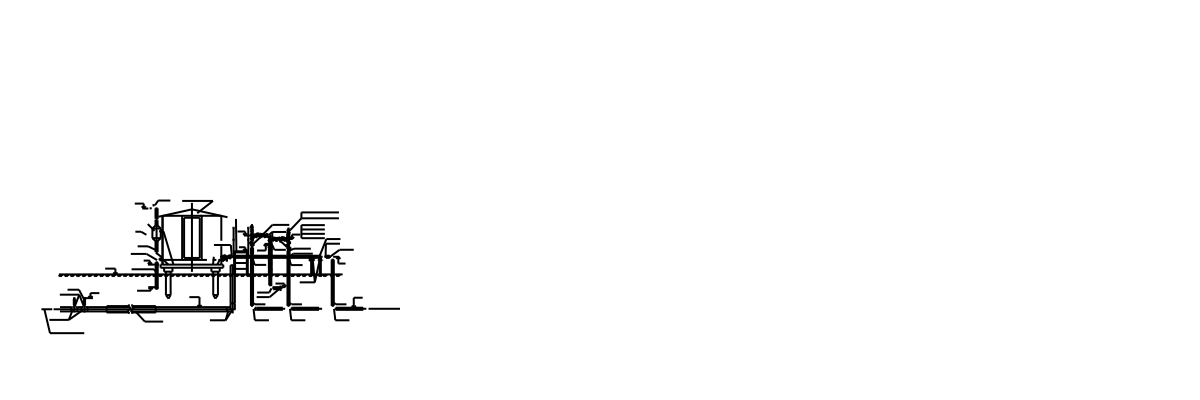

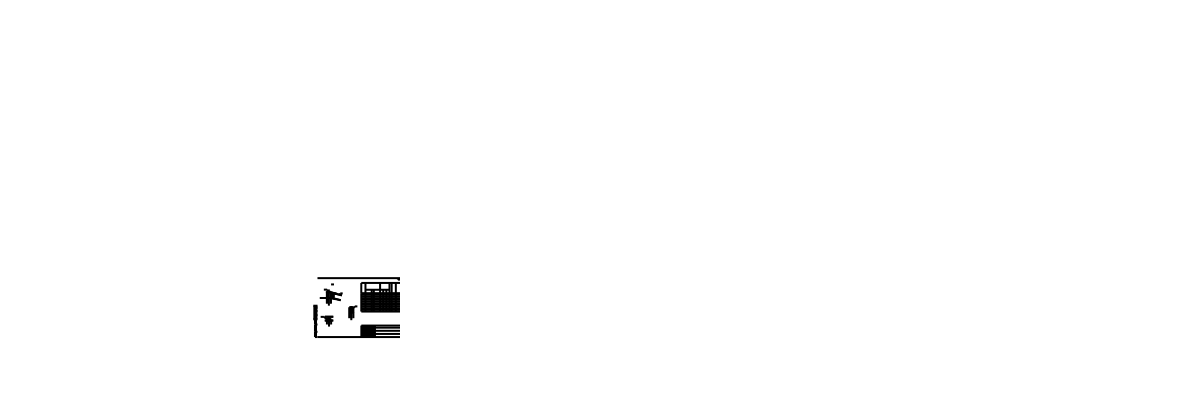

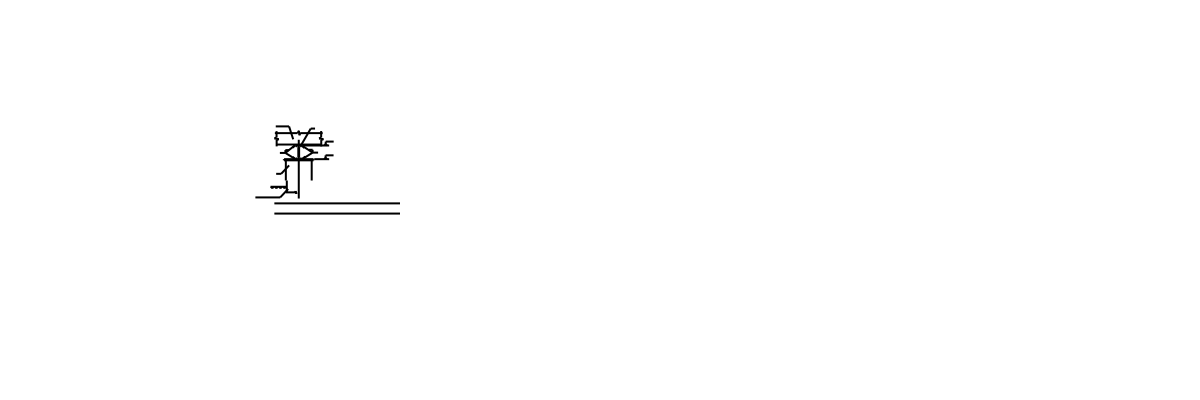

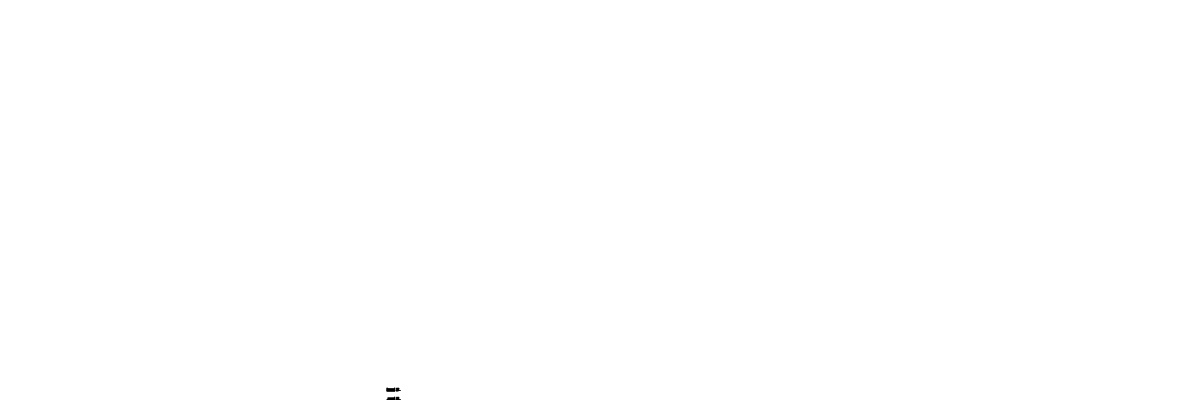

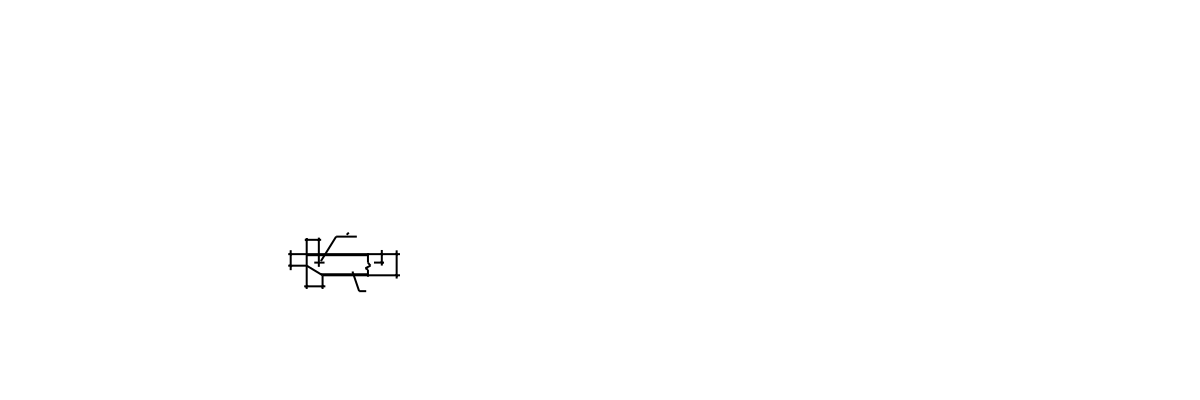

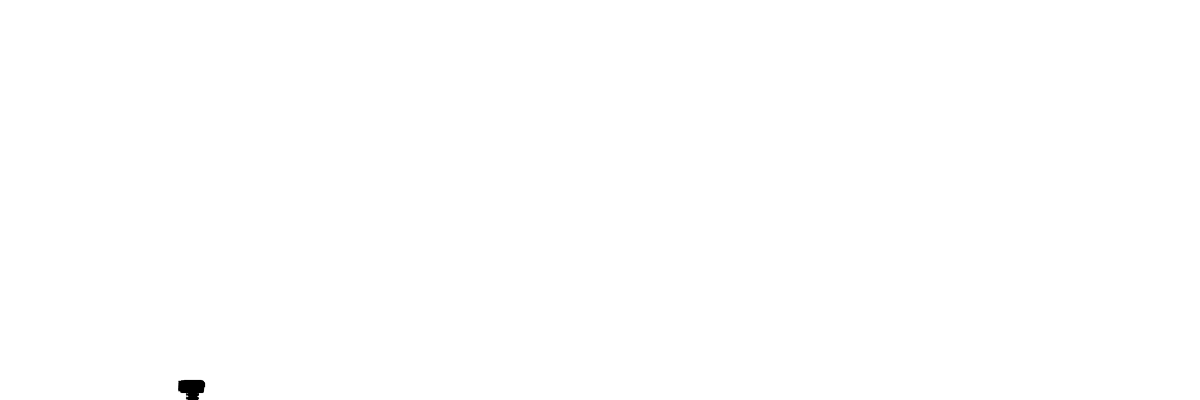

In [7]:
for i, batch in enumerate(dwg_dataset.train_loader):
    
    data = batch[0].to(device).transpose(0, 1)
    mask = batch[1].to(device).transpose(0, 1)
    
    for i in images_from_batch(data):
        display(i)
    #sampler = Sampler(encoder, decoder)
    #seq = sampler.sample(data, 0.4)
    #print(seq)
    break